# Flood Detector v0.1
This is a first draft of the Flooding Detector. The detector will use a pretrained model (ResNet50) to detected floodings on satellite imagery. The Training data (*Sen1Floods11*) was downloaded from GCS and is provived by the company *CloudToStreet*.

In [1]:
%matplotlib inline

In [2]:
# Make sure you have the right Kernel active.
# !source activate WIDnet
# !conda list
!conda env list

# conda environments:
#
base                  *  /home/vincent/anaconda3
WIDnet                   /home/vincent/anaconda3/envs/WIDnet



connect via ssh
jupyter notebook --no-browser --port 8200
ssh -NL 8201:localhost:8201 192.168.0.150

## Imports

In [3]:
import os.path 
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

from tensorflow import argmax, newaxis
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, AveragePooling2D, MaxPooling2D, Concatenate
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.utils import plot_model

import tensorflow.keras.losses as losses
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.metrics as metrics
import tensorflow.keras.optimizers as optim

from IPython.display import clear_output

import rasterio
from rasterio import plot

## Constants

In [4]:
### Paths ###
DS_PATH_ROOT = "../../Sen1Floods11/data/v1.1/"
DATA_PATH_ROOT = DS_PATH_ROOT + "data/"
DATA_PATH_IMAGES = DATA_PATH_ROOT + "flood_events/HandLabeled/S1Hand/"
DATA_PATH_LABELS = DATA_PATH_ROOT + "flood_events/HandLabeled/LabelHand/"

DS_PATH_SPLIT = DS_PATH_ROOT + "splits/flood_handlabeled/"
DS_PATH_SPLIT_TRAIN = DS_PATH_SPLIT + "flood_train_data.csv"
DS_PATH_SPLIT_VALID = DS_PATH_SPLIT + "flood_valid_data.csv"
DS_PATH_SPLIT_TEST  = DS_PATH_SPLIT + "flood_test_data.csv"

# proof path existence
assert os.path.exists(DATA_PATH_ROOT), DATA_PATH_ROOT + " does not exist"

In [5]:
def csv_split_to_list(csv_path, root_images, root_lables):
    '''Reads a csv split file and converts it to a python list containing tuples of format: (Image, labeled Image)'''
    l = []
    with open(csv_path) as f:
        for line in csv.reader(f):
            l.append((root_images + line[0], root_lables + line[1]))
    print(len(l), " Images were found.")
    return l

def load_ds_from_list(csv_list):
    '''Loads an Image Dataset by reading a list of paths and returns a 3d numpy array with shape (Image count, height, width, band count)'''
    images = []
    labels = []
    for image_path, label_path in csv_list:
        images.append(rasterio.open(image_path).read().transpose(1,2,0))
        labels.append(rasterio.open(label_path).read().transpose(1,2,0))
    return np.array(images), np.array(labels)

def load_ds(csv_path, root_images, root_lables):
    l = csv_split_to_list(csv_path, root_images, root_lables)
    return load_ds_from_list(l)

### Load Data
Load Images as nNumpy Arrays and plot random images. <br>
The data is Raw Sentinel-1 imagery of IW mode and dual polarisation. Hence, 2 channels are available: Band 0 is VV Polarisation, band 1 is VH. The product is of GRD type. The data is of type float32, the values are scaled in dB. Width and height are 512 pixels, spatial resoultion is 10m and the datafromat is GeoTIFF. <br>

The hand labeled ground truth images have 3 labels:
- -1: No Data / Not Valid
-  0: Not Water
-  1: Water.

In [6]:
ds_train_Img, ds_train_GT = load_ds(DS_PATH_SPLIT_TRAIN, DATA_PATH_IMAGES, DATA_PATH_LABELS)
ds_valid_Img, ds_valid_GT = load_ds(DS_PATH_SPLIT_VALID, DATA_PATH_IMAGES, DATA_PATH_LABELS)
ds_test_Img, ds_test_GT  = load_ds(DS_PATH_SPLIT_TEST,  DATA_PATH_IMAGES, DATA_PATH_LABELS)

252  Images were found.
89  Images were found.
90  Images were found.


In [7]:
def create_mask(pred):
    '''creates a 1 channel mask out of a n-channel label prediction by choosing the label with the highest score.'''
    mask = np.argmax(pred, axis=-1)
    mask = mask[..., np.newaxis]
    print(mask.shape)
    return mask

def plot_rand_imgs(N, imgs, gts, pred=None, id_of_interest=None, pos_bound=True, savepath='plots/default.png'):
    # create custom colormap for labeled images.
    gt_range = [-0.5, 0.5, 1.5, 2.5] if pos_bound else [-1.5, -0.5, 0.5, 1.5]
    gt_cmap = ListedColormap(['k', 'g', 'b'])
    gt_norm = BoundaryNorm(gt_range, gt_cmap.N, clip=False)
    
    # Number of columns in the subplot
    M = 4 if pred is None else 5
    
    # Pick random or specific indexies
    numbers = np.random.randint(low=0, high=len(imgs), size=N)
    if id_of_interest is not None:
        for i, num in enumerate(id_of_interest):
            numbers[i] = num
    
    # create subplot
    fig, ax = plt.subplots(N, M, figsize=(5 * M, 5 * N));
    ax = ax.flatten()

    for i, n in enumerate(numbers):
        # rasterio.plot.show_hist(imgs[n,:,:,0], ax=ax[M * i], bins=256)
        # rasterio.plot.show_hist(imgs[n,:,:,1], ax=ax[M * i], bins=256)
        ax[M * i].hist(imgs[n,:,:,0].flatten(), bins=256, label="Band 0: VV", histtype="step")
        ax[M * i].hist(imgs[n,:,:,1].flatten(), bins=256, label="Band 1: VH", histtype="step")
        ax[M * i].set_title("Histogramm of both bands")
        ax[M * i].legend()
        
        rasterio.plot.show(imgs[n,:,:,0], ax=ax[M * i + 1], title=f"Image ID {n}, Band 0: VV", cmap='Greys')
        rasterio.plot.show(imgs[n,:,:,1], ax=ax[M * i + 2], title=f"Image ID {n}, Band 1: VH", cmap='Greys')
        rasterio.plot.show(gts[n,:,:,0], ax=ax[M * i + 3], title=f"Image ID {n}, Ground Truth", cmap=gt_cmap, norm=gt_norm)
        if pred is not None:
            rasterio.plot.show(create_mask(pred[n]), ax=ax[M * i + 4], title=f"Image ID {n}, Prediction", cmap=gt_cmap, norm=gt_norm)
    
    fig.savefig(savepath)
    return fig, ax

(252, 512, 512, 1)


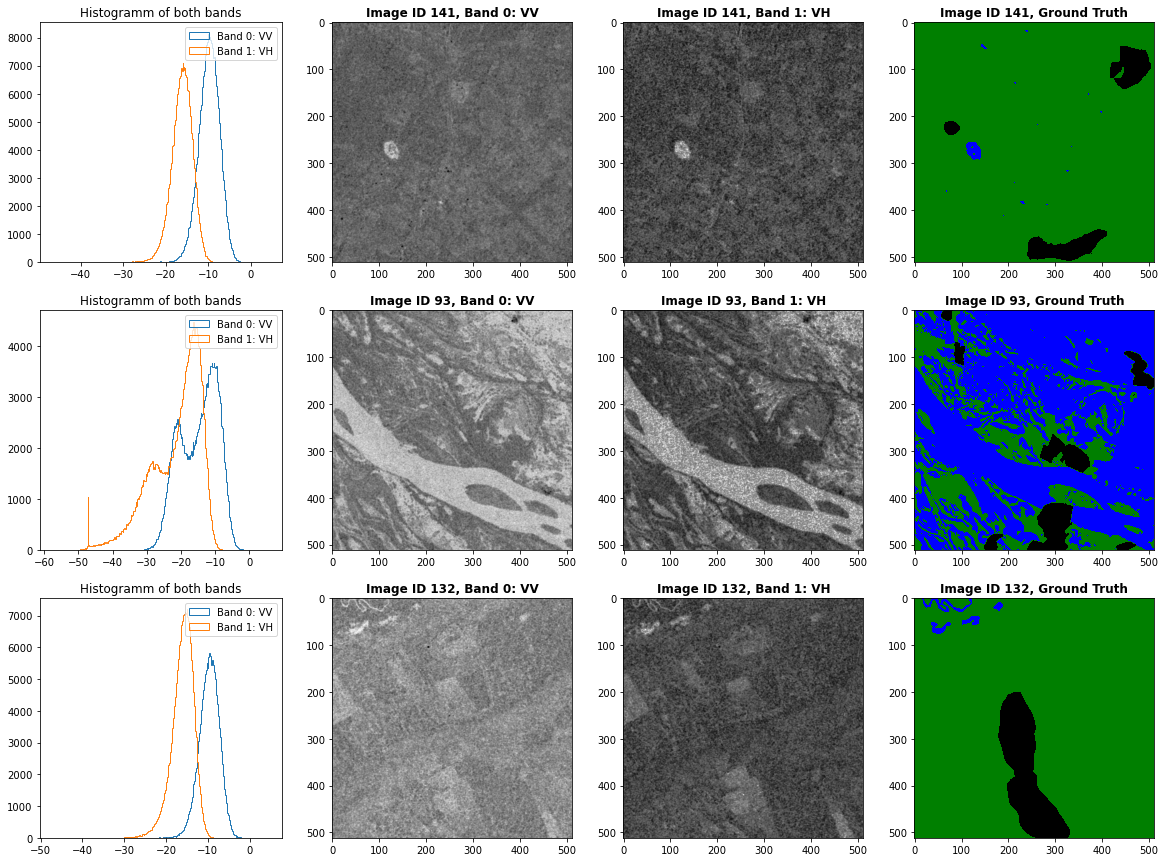

In [8]:
plot_rand_imgs(3, ds_train_Img, ds_train_GT, pos_bound=False);
print(ds_train_GT.shape)

---
## Preprocess Images
Before training and inference, the images must be preprocessed. Esspecially, three things need to be considered:
- The images contain NaN Pixels which would lead to problems while training. 
- Additionally, training data should be normalised to range [-1 ... 1].
- Ground truth labels should be non-negative integer values.

### Handle NaNs
We can replace NaNs with a numeric number. The problem is, which number should we use as a replacement. The replace-value should not be near the SAR-Value of water surfaces, as this could lead to false classifications. After oberserving some of the images pixel distributions, it seems that the best approach could be to set it to a value greater or equal to 0, to indicate that it is far away from any realistic SAR value and the classification as -1: No Data is supported. In the first **Flood Detection** version, it will be set to 0.

img 3 	 Max: 1.67, 	 Min: -29.26, 	 Type float32
img 4 	 Max: -0.77, 	 Min: -21.89, 	 Type float32
img 5 	 Max:  nan, 	 Min:  nan, 	 Type float32
img 6 	 Max: -1.07, 	 Min: -35.05, 	 Type float32


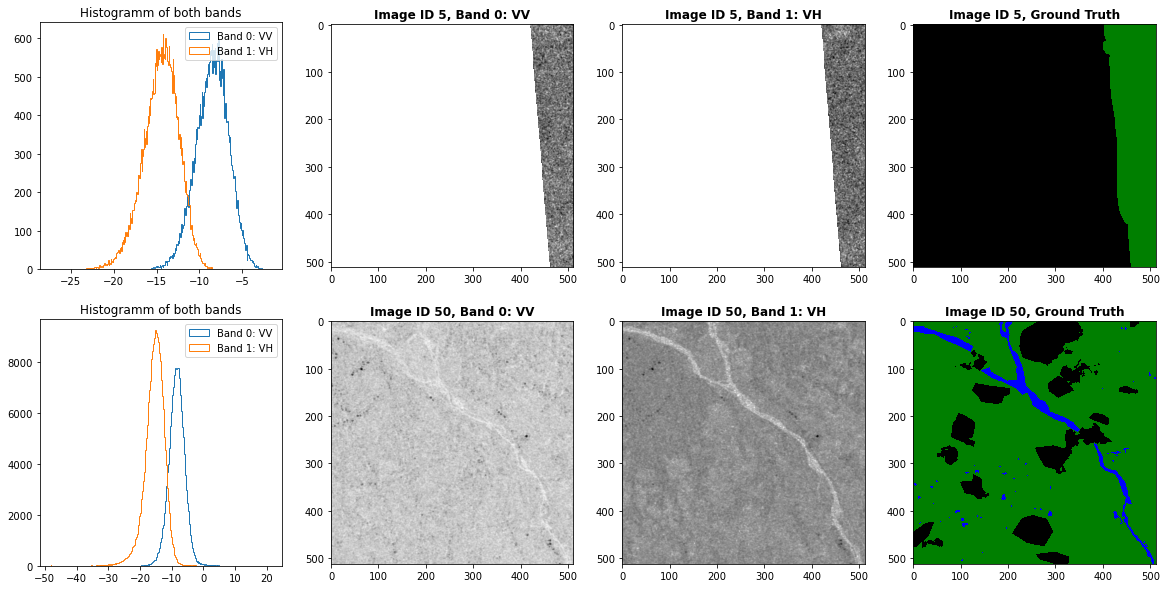

In [9]:
for i, img in enumerate(ds_train_Img[3:7]):
    print(f"img {i+3} \t Max: {img[:,:,0].max():4.2f}, \t Min: {img[:,:,0].min():4.2f}, \t Type {img.dtype}")
    
plot_rand_imgs(2, ds_train_Img, ds_train_GT, id_of_interest=[5, 50], pos_bound=False);

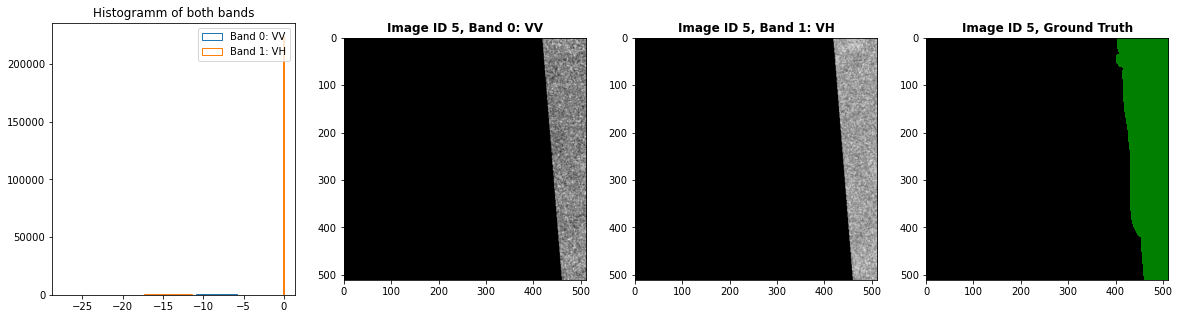

In [10]:
nan = 0
np.nan_to_num(ds_train_Img, copy=False, nan=nan)
np.nan_to_num(ds_valid_Img, copy=False, nan=nan)
np.nan_to_num(ds_test_Img, copy=False, nan=nan)

plot_rand_imgs(1, ds_train_Img, ds_train_GT, id_of_interest=[5], pos_bound=False);

### Normalization
Observations have shown that SAR values of water surface are distributed around -30dB for VH polarisation.

Max Value:  29.926394  Where:  (179, 94, 255, 0)
Min Value:  -79.161446  Where:  (52, 11, 488, 1)


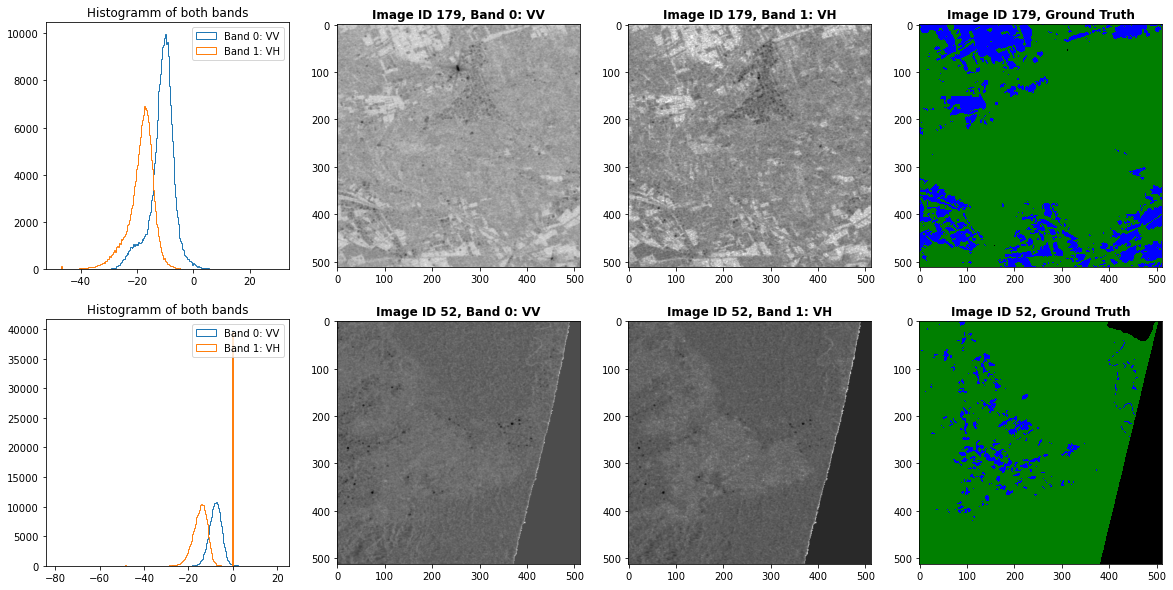

In [11]:
print("Max Value: ", ds_train_Img.max(), " Where: ", np.unravel_index(ds_train_Img.argmax(), ds_train_Img.shape))
print("Min Value: ", ds_train_Img.min(), " Where: ", np.unravel_index(ds_train_Img.argmin(), ds_train_Img.shape))

plot_rand_imgs(2, ds_train_Img, ds_train_GT, id_of_interest=[179, 52], pos_bound=False);

In [12]:
def easy_norm_SAR(ds, vmax=0, vmin=-40):
    # first clip to vmax and vmin, then scale linear
    l = []
    for img in (ds[:]):
        img = np.clip(img, a_min=vmin, a_max=vmax)
        img = 2 * img / (vmax - vmin) + 1  # (img / (vmax - vmin) + 1 ) *  256
        l.append(img)
    ds = np.array(l)
    return ds #preprocess_input(ds)

In [13]:
ds_train_Img_norm = easy_norm_SAR(ds_train_Img)
ds_valid_Img_norm = easy_norm_SAR(ds_valid_Img)
ds_test_Img_norm = easy_norm_SAR(ds_test_Img)

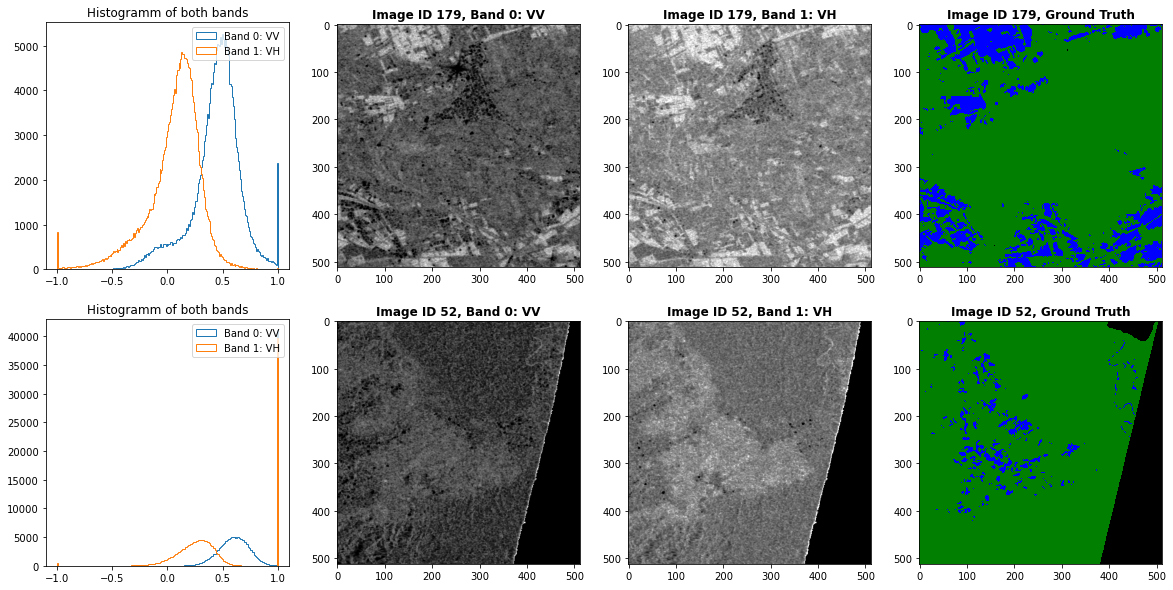

In [14]:
plot_rand_imgs(2, ds_train_Img_norm, ds_train_GT, id_of_interest=[179, 52], pos_bound=False);

In [15]:
for i, img in enumerate(ds_train_Img[:7]):
    print(f"img {i} \t Max: {img[:,:,0].max():4.2f}, \t Min: {img[:,:,0].min():4.2f}, \t Type {img.dtype}")

img 0 	 Max: 8.59, 	 Min: -39.31, 	 Type float32
img 1 	 Max: 2.37, 	 Min: -21.87, 	 Type float32
img 2 	 Max: 5.36, 	 Min: -24.41, 	 Type float32
img 3 	 Max: 1.67, 	 Min: -29.26, 	 Type float32
img 4 	 Max: -0.77, 	 Min: -21.89, 	 Type float32
img 5 	 Max: 0.00, 	 Min: -19.56, 	 Type float32
img 6 	 Max: -1.07, 	 Min: -35.05, 	 Type float32


In [16]:
# Cast the gt to float32
# ds_train_GT = ds_train_GT.astype('float32')
# ds_valid_GT = ds_valid_GT.astype('float32')
# ds_test_GT = ds_test_GT.astype('float32')
#ds_train_GT = preprocess_input(ds_train_GT)
#ds_valid_GT = preprocess_input(ds_valid_GT)

In [17]:
# push gt labels to positive values
ds_train_GT_norm = ds_train_GT + 1
ds_valid_GT_norm = ds_valid_GT + 1
ds_test_GT_norm = ds_test_GT + 1

In [18]:
for i, img in enumerate(ds_train_GT_norm[:7]):
    print(f"img {i} \t Max: {img[:,:,0].max():4.2f}, \t Min: {img[:,:,0].min():4.2f}, \t Type {img.dtype}")

img 0 	 Max: 2.00, 	 Min: 0.00, 	 Type int16
img 1 	 Max: 2.00, 	 Min: 1.00, 	 Type int16
img 2 	 Max: 2.00, 	 Min: 1.00, 	 Type int16
img 3 	 Max: 2.00, 	 Min: 1.00, 	 Type int16
img 4 	 Max: 1.00, 	 Min: 0.00, 	 Type int16
img 5 	 Max: 1.00, 	 Min: 0.00, 	 Type int16
img 6 	 Max: 2.00, 	 Min: 1.00, 	 Type int16


---
## Model Design

The model will have a modified U-NET Architecture. To reduce the number of training paramaters and thereby reduce the number of training parameters, we will take advantage of transfer learning. As encoder, a pretrained model will be used. In the first flood detector version, the model will be MobileNetV2. As decoder, multiple custom upsample layers will be used. Additionally, skip connectors from layers in the encoder will connect layers of the decoder. 

In [19]:
### CONSTANTS ###
INPUT_SHAPE = ds_test_Img_norm[0].shape

Most pretrained models expect an input of shape (Imsize, Imsize, Channels=3). Since we only have 2 channels, a Conv2d Layer is prepended to the encoder.

In [20]:
clear_session()

### Initialize top model ###
top_downsampler = Sequential()

top_downsampler.add(Input(INPUT_SHAPE))
top_downsampler.add(Conv2D(filters=3, kernel_size=(3,3), strides=2, padding='same', activation='relu'))
top_downsampler.add(Conv2D(filters=3, kernel_size=(3,3), strides=2, padding='same', activation='relu'))

# for easy of use at the beginning of the project we will just downsample the image
top_downsampler = Sequential()

top_downsampler.add(Input(INPUT_SHAPE))
top_downsampler.add(AveragePooling2D(pool_size=(4,4), padding='same'))
top_downsampler.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='tanh'))  # tanh activation: MobileNetV2 expexts the input to be [-1 ... 1]


### Initialize pretrained model ###
pretrained_downsampler = MobileNetV2(input_shape=(128, 128, 3), include_top=False)

### prepare skip connectors
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
pretrained_downsampler_outputs = [pretrained_downsampler.get_layer(name).output for name in layer_names]


### compose encoders ###
encoder_top = Model(inputs=top_downsampler.input, outputs=top_downsampler.output)
encoder_bot = Model(inputs=pretrained_downsampler.input, outputs=pretrained_downsampler_outputs)

encoder_bot.trainable = False

### initialize decoder ###
def upsample(filters, kernel_size=(3,3), padding='same', activation='relu'):
    model = Sequential()
    model.add(Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, padding='same', activation=activation))
    return model

decoder = [
    upsample(512),
    upsample(256),
    upsample(128),
    upsample(64),
    upsample(32),
]

Since all models are initialized now, the encoders and decoder can be stacked. Additionally skip connections will be established.

In [21]:
inputs = Input(shape=(512, 512, 2))

high_level_features = encoder_top(inputs)

mid_to_low_level_features = encoder_bot(high_level_features)

for i in mid_to_low_level_features:
    print(i.shape)
print(30 * "-")

(None, 64, 64, 96)
(None, 32, 32, 144)
(None, 16, 16, 192)
(None, 8, 8, 576)
(None, 4, 4, 320)
------------------------------


In [22]:
#print(decoder)

In [23]:
def create_unet():
    inputs = Input(shape=(512, 512, 2))
    
    high_level_features = encoder_top(inputs)
    
    # preprocess high level features
    # high_level_features = preprocess_input(high_level_features)  ?????? Should I do that
    
    # create a list with all skip levels
    mid_to_low_level_features = encoder_bot(high_level_features)
    
    # Downsampling through model. It is enough to call the last element
    x = mid_to_low_level_features[-1]
    
    # prepare skip connection establishing
    skips = reversed(mid_to_low_level_features[:-1])  # ?
    
    # Upsampling and establish skip connections
    for up, skip in zip(decoder, skips):
        x = up(x)  # go one layer up
        x = Concatenate()([x, skip])  # establish skip connection
        
    # prepare output
    x = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    outputs = Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    
    return Model(inputs=inputs, outputs=outputs)

### Callbacks
Custom Callbacks to print out live training progress.

In [24]:
class PlotTrainingProgress(callbacks.Callback):
    '''Live plot of the training progress.'''
    
    def __init__(self, clear=True):
        self.clear = clear
    
    def on_train_begin(self, logs={}):
        '''Initialize all metrics on training begin.'''
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
        
    def on_epoch_end(self, epoch, logs=None):
        '''Extract updates from logs, then clear output and plot training graph.'''
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        if self.clear:
            clear_output(wait=True)
            
        metrics = [metric for metric in logs if 'val' not in metric]
        
        self.fig, self.ax = plt.subplots(1, len(metrics), figsize=(15,5))

        for i, metric in enumerate(metrics):
            self.ax[i].plot(range(1, epoch + 2), self.metrics[metric], label=metric)
            
            if 'val_' + metric in logs:
                self.ax[i].plot(range(1, epoch + 2), self.metrics['val_' + metric], label='val_' + metric)

            self.ax[i].legend()
            self.ax[i].grid()

        plt.tight_layout()
        plt.show()
        
    def on_train_end(self, logs=None):
        self.fig.savefig("plots/train_val_loss.png")   
        
        
class ShowSegmentationPrediction(callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        ID = 1
        pred = self.model.predict([ds_test_Img_norm[ID]])
        plot_rand_imgs(1, ds_test_Img_norm[ID], ds_test_GT[ID], pred=pred, id_of_interest=[ID]);

In [25]:
### Custom Metrics

In [26]:
def SparseIoU(y_true, y_pred):
    mask = argmax(y_pred, axis=-1)
    mask = mask[..., newaxis]
        
    iou = metrics.MeanIoU(3)
    iou.update_state(y_true, mask)
    
    return iou.result() #.numpy()
    

### Compilation

In [27]:
LR = 1e-2
OPTIMIZER = optim.SGD(learning_rate=LR)
LOSS = losses.SparseCategoricalCrossentropy(from_logits=True)
METRICS = [
    metrics.SparseCategoricalAccuracy(),
   # metrics.MeanIoU(3)
   # SparseIoU,
]

In [28]:
flood_detector = create_unet()
                      
flood_detector.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS  #METRICS
)

In [29]:
# flood_detector.summary()

In [30]:
# plot_model(flood_detector, show_shapes=True, expand_nested=False)

### Training

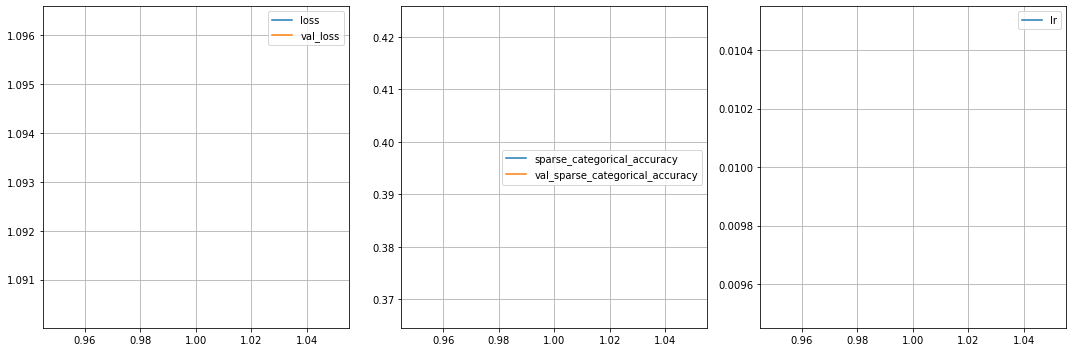

Epoch 2/50
2/8 [======>.......................] - ETA: 3:24 - loss: 1.0895 - sparse_categorical_accuracy: 0.4298

In [ ]:
CALLBACKS = [
    callbacks.ModelCheckpoint("flood_prediction.h5", save_best_only=True),
    callbacks.CSVLogger("logs/training.log"),
    callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=True),
    callbacks.TerminateOnNaN(),
    PlotTrainingProgress(),
    #ShowSegmentationPrediction(),
]

history = flood_detector.fit(
    ds_train_Img_norm, 
    ds_train_GT_norm, 
    batch_size=32,
    #steps_per_epoch=2,
    validation_data=(ds_valid_Img_norm, ds_valid_GT_norm), 
    epochs=50, 
    verbose=True,
    callbacks=CALLBACKS
);

In [ ]:
preds = flood_detector.predict(ds_test_Img_norm);

In [ ]:
# plt.imshow(create_mask(preds[76]), cmap='gray')
print(SparseIoU(ds_test_GT[0], preds[0]))

In [ ]:
print(ds_test_Img_norm[i].shape)
print(preds.shape)

#for i in range(len(preds)):
#    preds[i] /= preds[i].max()

for i, img in enumerate(preds[3:7]):
    print(f"img {i+3} \t Max: {img[:,:,0].max():4.2f}, \t Min: {img[:,:,0].min():4.2f}, \t Type {img.dtype}")

In [ ]:
plot_rand_imgs(10, ds_test_Img_norm, ds_test_GT_norm, preds, savepath='plots/predictions.png');

### Load Model from h5 file

In [ ]:
flood_detectorh5 = load_model("flood_prediction.h5")

In [ ]:
preds_h5 = flood_detectorh5.predict(ds_test_Img_norm)

In [ ]:
plot_rand_imgs(10, ds_test_Img, ds_test_GT_norm, preds_h5, savepath='plots/predictionsh5.png');

In [ ]:
for i, img in enumerate(preds_h5[:7]):
    img = create_mask(img)
    print(f"img {i+3} \t Max: {img[:,:,0].max():4.2f}, \t Min: {img[:,:,0].min():4.2f}, \t Type {img.dtype}")
    
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(preds_h5[0,:,:,0], cmap='gray', vmin=0, vmax=1)
ax[1].imshow(preds_h5[0,:,:,1], cmap='gray', vmin=0, vmax=1)
ax[2].imshow(preds_h5[0,:,:,2], cmap='gray', vmin=0, vmax=1)